In [1]:
# General
import numpy as np
import pandas as pd
import re
import nltk

# Data Exploration

import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

np.random.seed(42)

In [3]:
df  = pd.read_csv('/Disaster_Tweets_Train.csv')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

In [6]:
temp = pd.DataFrame()
temp['Label'] = ['Real Disaster','No Disaster']
temp['Count'] = [len(df[df['target'] == 1]), len(df[df['target'] == 0])]
temp = temp.sort_values(by = ['Count'], ascending = False)
fig = px.bar(temp, x = 'Label', y = 'Count', 
             color = "Label", text_auto='', width = 600, 
             color_discrete_sequence = ["#AB63FA", "orange"],
             template = 'plotly_dark',
            title = "Count Plot")

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size=12, textangle = 0, textposition = "outside", cliponaxis = False)
fig.show()

In [8]:
# Finding the WORD-COUNT
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df[df['target']==1]['word_count'].mean()) #Disaster tweets
print(df[df['target']==0]['word_count'].mean()) #Non-Disaster tweets
#Disaster tweets are more wordy than the non-disaster tweets


15.167532864567411
14.704744357438969


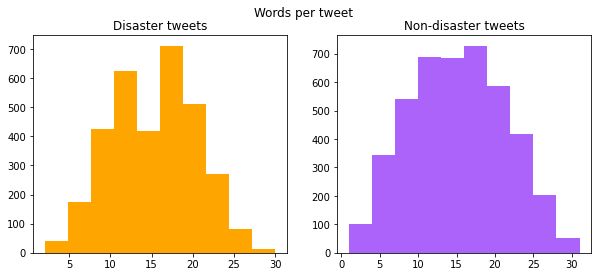

In [10]:
#Plotting word-count per tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df['target']==1]['word_count']
ax1.hist(train_words,color='orange')
ax1.set_title('Disaster tweets')
train_words=df[df['target']==0]['word_count']
ax2.hist(train_words,color='#AB63FA')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

# Pre-Processing

In [11]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

In [12]:
#1. STOPWORD REMOVAL
from nltk.corpus import stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. STEMMING
 
# Initialize the stemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

#3. LEMMATIZATION
# Initialize the lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
wl = WordNetLemmatizer()
 
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df['clean_text'] = df['text'].apply(lambda x: finalpreprocess(x))
df.head()

,id,keyword,location,text,target,word_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,get sent photo ruby alaska smoke wildfires pou...


# Train Test Split

In [23]:
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  shuffle=True
)

In [24]:
df_train.shape, df_test.shape

((6090, 7), (1523, 7))

In [25]:
#Creating training data
train_data = df_train.clean_text.tolist()
train_labels = df_train.target.tolist()

#Creating testing data
test_data = df_test.clean_text.tolist()
test_labels = df_test.target.tolist()

# Machine Learning Models

In [26]:
%%time
lr_model = LogisticRegressionCV(class_weight='balanced', max_iter=400)
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced')
mnb_model = MultinomialNB()
svm_model = SVC(class_weight='balanced')
knn_model = KNeighborsClassifier()
ada_model = AdaBoostClassifier()
model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes', 'SVM', 'KNN', 'AdaBoost']
ml_models = [lr_model,dt_model,rf_model,mnb_model, svm_model, knn_model, ada_model]

CPU times: user 193 µs, sys: 0 ns, total: 193 µs
Wall time: 198 µs


**Pipeline using TF-IDF Vectorizer**

In [27]:
%%time
def model_train(model, train_data, train_labels):
  pipe = Pipeline([
        ('FE', TfidfVectorizer(ngram_range=(1,2), use_idf = True, tokenizer=lambda x: x.split(), max_features=20000)),  
        ('Transformer', TfidfTransformer()),  
        ('M', model)
    ])
  pipe.fit(train_data, train_labels)
  return pipe

trained_ml_models = []
for i in ml_models:
    tt = model_train(i,train_data, train_labels)
    trained_ml_models.append(tt)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

CPU times: user 42.7 s, sys: 30.3 s, total: 1min 12s
Wall time: 46.3 s


**Performance on Training Data**

In [28]:
pr_list = []
re_list = []
f1_list = []
acc_list = []

def print_results(md, x_train, y_train, name):
    #print("\n\nClassifier: ", name)
    pred_y = md.predict(x_train)
    true, pred = y_train, pred_y
    
    pr_list.append((round(precision_score(y_train, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_train, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_train, pred_y, average='weighted'),4)*100))
    acc_list.append((round(accuracy_score(y_train, pred_y),4)*100))

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    print_results(md, train_data, train_labels, name)

performance_matrix = pd.DataFrame({'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,'Accuracy':acc_list},
                                  index =model_names)
performance_matrix

,Precision,Recall,F1 Score,Accuracy
Logistic Regression,90.82,90.71,90.65,90.71
Decision Tree,99.48,99.47,99.47,99.47
Random Forest,99.47,99.47,99.47,99.47
Naive Bayes,91.98,91.33,91.20,91.33
SVM,98.26,98.26,98.26,98.26
KNN,77.29,65.73,58.63,65.73
AdaBoost,77.32,76.17,75.25,76.17


Performance on Test Data

In [29]:
pr_list = []
re_list = []
f1_list = []
acc_list = []

def print_results(md, x_test, y_test, name):
    #print("\n\nClassifier: ", name)
    pred_y = md.predict(x_test)
    true, pred = y_test, pred_y
    # print(confusion_matrix(true,pred))
    # print(classification_report(true,pred))
    # print("\nPrecison : ",precision_score(pred,true, average = 'weighted'))
    # print("\nRecall : ",recall_score(pred,true,  average = 'weighted'))
    # print("\nF1 : ",f1_score(pred,true,  average = 'weighted'))

    pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))
    acc_list.append((round(accuracy_score(y_test, pred_y),4)*100))

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    print_results(md, test_data, test_labels, name)

performance_matrix = pd.DataFrame({'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,'Accuracy':acc_list},
                                  index =model_names)
performance_matrix

,Precision,Recall,F1 Score,Accuracy
Logistic Regression,79.20,79.25,79.22,79.25
Decision Tree,69.66,69.80,69.71,69.80
Random Forest,79.10,78.14,77.39,78.14
Naive Bayes,79.94,79.12,78.49,79.12
SVM,80.56,80.56,80.38,80.56
KNN,77.60,65.07,57.14,65.07
AdaBoost,74.72,74.33,73.55,74.33
